# Load required libs

In [1]:
%cd ..
%pwd
import sys
sys.path.append('./src')
from src.data_processor import RawDataProcessor
from src.problem_config import create_prob_config
from src.drift_detector import ks_drift_detect
prob_config = create_prob_config("phase-3", "prob-2")

c:\VENV\api_prediction


In [2]:
from mlflow.models.signature import infer_signature
import mlflow

def log_model_to_tracker_lgbm(model, metrics, desc):
    MLFLOW_TRACKING_URI = 'http://192.168.88.113:5000'
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment("phase-3_prob-2_lgbm")
    MLFLOW_MODEL_PREFIX = "model"
    mlflow.start_run(description=desc)
    mlflow.log_metrics(metrics)
    mlflow.log_params(model.get_params())
    signature = infer_signature(test_x.astype(np.float64), predictions)
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path=MLFLOW_MODEL_PREFIX,
        signature=signature,
        pip_requirements ='src/requirements.txt'
        #registered_model_name="phase-1_prob-1_model-1"
    )

    experimentid = mlflow.active_run().info.run_id
    mlflow.end_run()
    return experimentid

# Prepare datasets

In [197]:
# Import xtran and ytrain
import pandas as pd
import numpy as np
import pickle

training_data = pd.read_parquet(prob_config.raw_data_path)
training_data = training_data.drop_duplicates()

training_data, category_index = RawDataProcessor.build_category_features(
            training_data, prob_config.categorical_cols
        )

with open(prob_config.category_index_path, "wb") as f:
    pickle.dump(category_index, f)

In [198]:
conflict_labels = training_data[training_data.duplicated(prob_config.feature_cols, keep=False)].sort_values(by=prob_config.feature_cols)
conflict_labels["org_idx"] = conflict_labels.index

In [199]:
data_conflict = conflict_labels.groupby(prob_config.feature_cols).agg({"org_idx": lambda x: tuple(x), "label": lambda x: tuple(x)}).reset_index()
#apply(lambda x: tuple(x.index)).to_list()

In [200]:
from sklearn.model_selection import train_test_split

training_data.drop_duplicates(subset=prob_config.feature_cols, keep=False, inplace=True)
target_col = prob_config.target_col
train_x0 = training_data.drop([target_col], axis=1)
train_y0 = training_data[[target_col]]

train, dev = train_test_split(training_data, test_size=0.1, random_state=123)

train_x = train.drop(["label"], axis=1)
train_y = train[[target_col]]
test_x = dev.drop(["label"], axis=1)
test_y = dev[[target_col]]

In [228]:
from lightgbm import LGBMClassifier

eval_set = [(train_x, train_y), (test_x, test_y)]
model0 = LGBMClassifier(objective="multiclass", random_state=123, boosting_type='dart')
model0.fit(train_x0, train_y0, verbose=False)#, eval_set=eval_set)

c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(boosting_type='dart', objective='multiclass', random_state=123)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

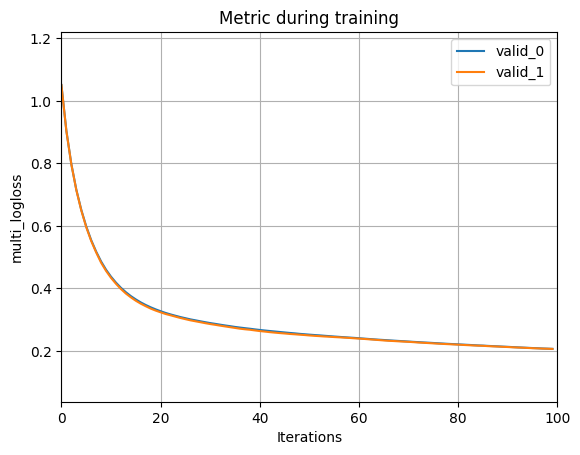

In [204]:
import lightgbm as lgb

lgb.plot_metric(model0)

In [207]:
# conflict_labels = data_conflict['label']
# proba_fix = pd.DataFrame(model0.predict_proba(data_conflict[prob_config.feature_cols]), columns=list(model0.classes_))
# fix_label = []
# for i in range(len(conflict_labels)):
#     labels = conflict_labels[i]
#     fix_label.append(labels[proba_fix[list(labels)].iloc[i].argmax()])

# fix_label = pd.DataFrame(fix_label)

# train_x_new = pd.DataFrame(np.concatenate((train_x0, data_conflict[prob_config.feature_cols])), columns=train_x.columns)
# train_y_new = pd.DataFrame(np.concatenate((train_y0, fix_label)), columns=train_y.columns)



# model1 = LGBMClassifier(objective="binary", random_state=123, is_unbalance=True)
# model1.fit(train_x_new, train_y_new, verbose=False)

c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(is_unbalance=True, objective='binary', random_state=123)

In [229]:
from sklearn.metrics import accuracy_score
predictions = model0.predict(test_x)
#predictions = s.predict_model(best[0], data = test_x)["prediction_label"]
accuracy = accuracy_score(predictions, test_y)
metrics = {"accuracy_score": accuracy}
print(f"metrics: {metrics}")

metrics: {'accuracy_score': 0.8917154811715481}


In [171]:
data22 = pd.read_parquet('data/phase-2/prob-2/raw_train.parquet')

data22 = RawDataProcessor.apply_category_features(
    raw_df=data22,
    categorical_cols=prob_config.categorical_cols,
    category_index=category_index,
)

data22.drop_duplicates(inplace=True)

In [172]:
conflict_labels2 = data22[data22.duplicated(prob_config.feature_cols, keep=False)].sort_values(by=prob_config.feature_cols)
conflict_labels2["org_idx"] = conflict_labels2.index
conflict_labels2.groupby(prob_config.feature_cols).agg({"org_idx": lambda x: tuple(x), "label": lambda x: tuple(x)}).reset_index()[["org_idx","label"]]

,org_idx,label
0,"(18610, 61207)","(Exploits, Denial of Service)"
1,"(16762, 25916, 46019)","(Denial of Service, Exploits, Information Gath..."
2,"(10701, 59138, 59472)","(Exploits, Information Gathering, Denial of Se..."
3,"(32122, 43251, 57080)","(Information Gathering, Denial of Service, Exp..."
4,"(4625, 12609, 23488, 40864)","(Malware, Denial of Service, Exploits, Informa..."
...,...,...
1659,"(2052, 12187, 56610)","(Denial of Service, Exploits, Information Gath..."
1660,"(13656, 37184, 50897)","(Exploits, Information Gathering, Denial of Se..."
1661,"(6358, 11822, 55169)","(Exploits, Denial of Service, Information Gath..."
1662,"(2594, 12669)","(Exploits, Denial of Service)"


In [217]:
data22.drop_duplicates(subset=prob_config.feature_cols, keep=False, inplace=True)

train_x_new = pd.DataFrame(np.concatenate((train_x0, data22[prob_config.feature_cols])), columns=train_x.columns)
train_y_new = pd.DataFrame(np.concatenate((train_y0, data22[[prob_config.target_col]])), columns=train_y.columns)

model2 = LGBMClassifier(objective="binary", random_state=123, is_unbalance=True)
model2.fit(train_x_new, train_y_new, verbose=False)

c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(is_unbalance=True, objective='binary', random_state=123)

In [218]:
data22.drop_duplicates(subset=prob_config.feature_cols, keep=False, inplace=True)
accuracy_score(model2.predict(data22.drop([target_col], axis=1)), data22[[target_col]])

0.9044202342100212

In [45]:
%%timeit -n 10
model0.predict_proba(test_x)

71.9 ms ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [153]:
import lleaves
model_path = ".venv/phase2_2_lgbm.txt"
model0.booster_.save_model(filename=model_path)
llvm_model = lleaves.Model(model_file=model_path)
llvm_model.compile()

In [192]:
%%timeit -n 10
z = llvm_model.predict(test_x)
labels = np.argmax(z, axis=1)
classes = model0.classes_
labels = [classes[i] for i in labels]

16 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [222]:
run_description = """
### Header
LGBM model, First Base Model Prob2
Model: LGBM
    """
log_model_to_tracker_lgbm(model2, metrics, run_description)

'6301be2cdcfe47afb14da2424e8c124b'

# Drift Detection 

In [10]:
# Save referent for drift detection.
X_baseline = train_x0.sample(1000)
X_baseline_df = pd.DataFrame(X_baseline, columns=prob_config.drift_cols)
X_baseline_df.to_parquet(prob_config.driff_ref_path, index=False)

# Model drift

In [9]:
import pandas as pd
import redis
import pickle
# Load data for problem 1
rc2 = redis.Redis(host='localhost', db=2, port=6379)

captured_x = pd.DataFrame()
for key in rc2.keys():
    captured_data = pickle.loads(rc2.get(key))
    captured_x = pd.concat([captured_x, captured_data])

#captured_x.drop_duplicates(inplace=True, ignore_index=True)

#captured_x = apply_category_features(
#    raw_df=captured_x[train_x0.columns],
#    categorical_cols=prob_config.categorical_cols,
#    category_index=category_index,
#)

In [10]:
captured_x

,feature17,feature37,feature6,feature4,feature11,feature27,feature34,feature22,feature3,feature29,...,feature1,feature15,feature28,feature18,feature8,feature41,feature35,feature31,feature10,feature39
0,0.000000,0.0,-2.315934,INT,4.256000e+08,0.000000e+00,0.492686,0.0,-,0.0,...,0.000010,372.107265,0.0,0.000000,4667.444206,0.0,-2.004091,2.0,68.209288,2.639593
1,8866.796943,0.0,-3.273952,FIN,1.008715e+04,5.650000e+02,0.313822,255.0,http,3924.0,...,1.240390,316.660025,1.0,7763.113809,5326.917090,0.0,3.638178,0.0,53.093191,3.214469
2,18.661908,0.0,-3.687166,FIN,1.422364e+06,6.610000e+02,1.575556,255.0,-,0.0,...,0.016294,-439.369067,0.0,18.196987,5439.471865,0.0,0.023476,0.0,76.989293,2.879847
3,0.000000,0.0,-1.859722,INT,8.400000e+07,0.000000e+00,0.590194,0.0,-,0.0,...,0.000008,-122.402656,0.0,0.000000,-1532.726454,0.0,-7.390149,2.0,84.509609,3.899141
4,0.000000,0.0,-7.013076,INT,0.000000e+00,0.000000e+00,0.250888,0.0,-,0.0,...,0.000000,-567.023876,0.0,0.000000,2081.799772,1.0,-11.181647,2.0,58.613624,3.695266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.0,-2.315604,INT,1.000000e+08,6.658514e-09,0.782214,0.0,-,0.0,...,0.000008,308.238249,0.0,0.000000,900.130696,0.0,-8.494361,2.0,37.602370,4.515803
996,0.000000,0.0,-4.264351,INT,2.000000e+08,0.000000e+00,1.332541,0.0,-,0.0,...,0.000004,98.219524,0.0,0.000000,6944.998493,0.0,2.404023,2.0,47.146412,3.123270
997,6673.116690,0.0,-6.366335,FIN,3.358990e+03,7.100000e+01,0.475187,255.0,dns,0.0,...,1.112239,-59.633238,0.0,251.124297,5069.522457,0.0,3.763291,1.0,44.138606,3.416183
998,6540.847392,0.0,-6.006549,FIN,4.984898e+03,4.500000e+01,0.290594,255.0,-,0.0,...,1.092901,25.613197,0.0,345.025125,-2638.345765,0.0,-3.429945,1.0,36.443458,2.831593


In [14]:
rc2.flushdb()

True

In [18]:
len(rc2.keys())

293

In [ ]:
np_captured_x = captured_x.copy() #drop(["is_drift", "batch_id"], axis=1)
np_captured_x = np_captured_x.astype(train_x.dtypes.to_dict())
np_captured_x['label'].fillna(-1, inplace=True)

In [2]:
allkey = rc2.keys()